# Caffeine LOD Testing
Created by Hans Gaensbauer for the MIT Climate and Sustainability Consortium </br>2-9-2023

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from NMR import JEOL_parser as jeol

In [3]:
initial_concentration = 0.00257479787/0.045

ns = 8
cutoff = 19
dlen = 39328
data = np.zeros((ns, dlen), dtype = np.complex128)
zero_point = 0
base_freq = 0

folder = "../data/nmr_data/"

for i in range(ns):
    filename = (folder + "Caffeine-%d_CARBON-2-1.jdf" % (i + 1))
    data[i] = jeol.get_1d_data(filename)

zero_point = jeol.get_header(filename)["Zero_Point"][0]
base_freq = jeol.get_header(filename)["Base_Freq"][0]
    
t = jeol.get_ruler(filename)

<IPython.core.display.Javascript object>


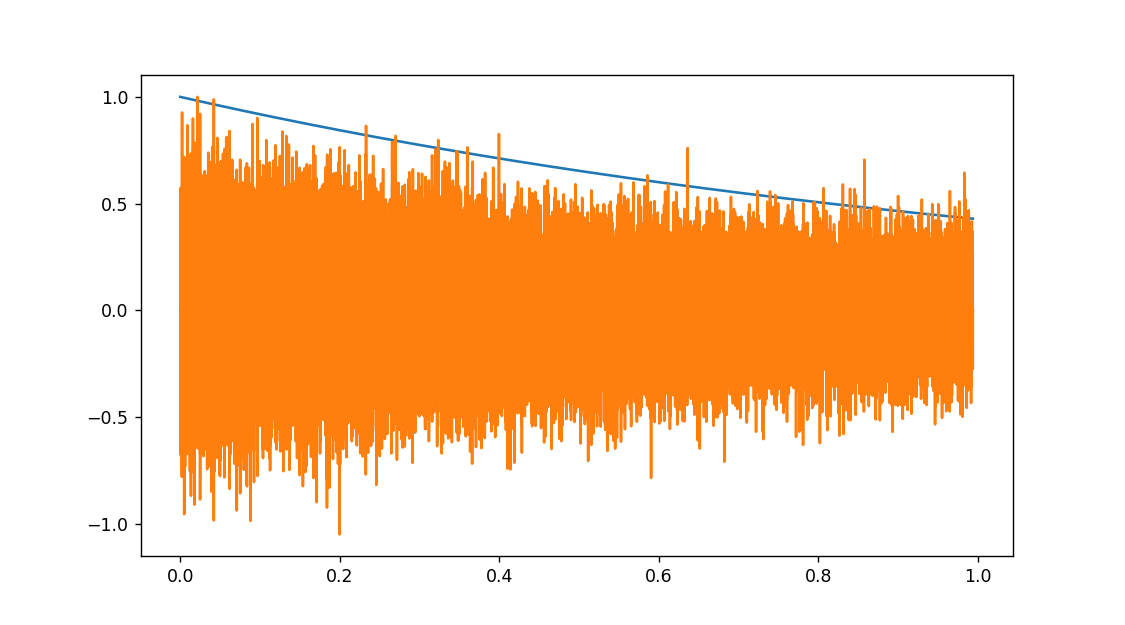

In [4]:
#Set the spectral width
sexp = np.exp(-0.85*(t-t[0]))

#plot the exponential with one of the FIDs
sexp_plot = plt.figure(figsize=(9,5))
plt.plot(t, sexp)
plt.plot(t, np.real(data[0])/np.real(data[0]).max())

<IPython.core.display.Javascript object>


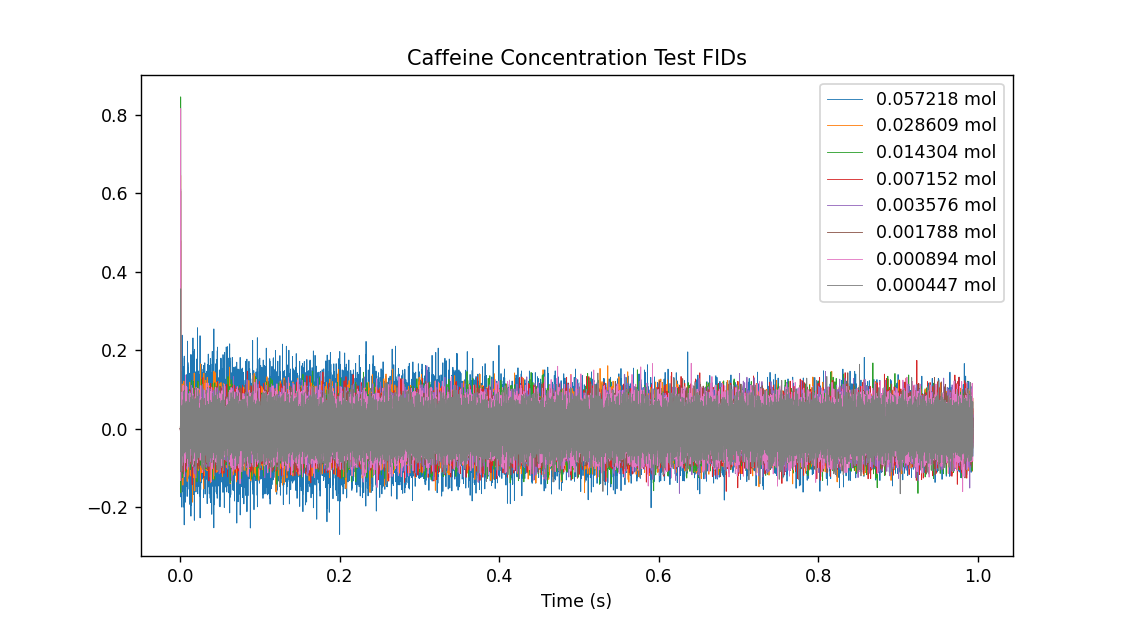

In [4]:
#plim = 128

#plot the FIDs
fid_plot = plt.figure(figsize=(9,5))
for i in range(ns):
    plt.plot(t[:], np.real(data[i][:]), linewidth=0.5)
    
plt.legend([("%f mol" % (initial_concentration/2**i)) for i in range(ns)])
plt.title("Caffeine Concentration Test FIDs")
plt.xlabel("Time (s)")
plt.show()

<IPython.core.display.Javascript object>


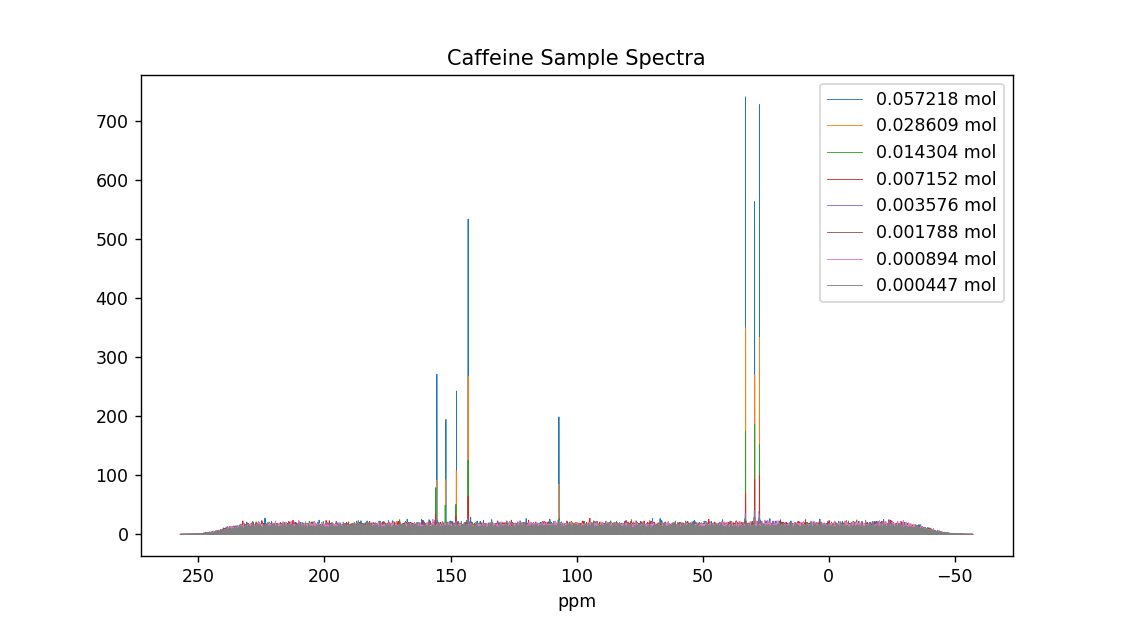

In [5]:
spectra = np.zeros((ns, dlen), dtype = np.complex128)
ppm = np.zeros((ns, dlen))

#Create Spectra
for i in range(ns):
    spectra[i] = np.fft.fft(data[i] * sexp)
    ppm[i] = (zero_point/(t[1]-t[0]) - np.fft.fftfreq(len(data[i]), t[1]-t[0]))/base_freq #Convert to ppm

spec_plot = plt.figure(figsize=(9,5))
for i in range(ns):
    plt.plot(ppm[i], np.abs(spectra[i]), linewidth=0.5)
    
plt.legend([("%f mol" % (initial_concentration/2**i)) for i in range(ns)])
plt.gca().invert_xaxis()
plt.title("Caffeine Sample Spectra")
plt.xlabel("ppm")
plt.show()

<IPython.core.display.Javascript object>


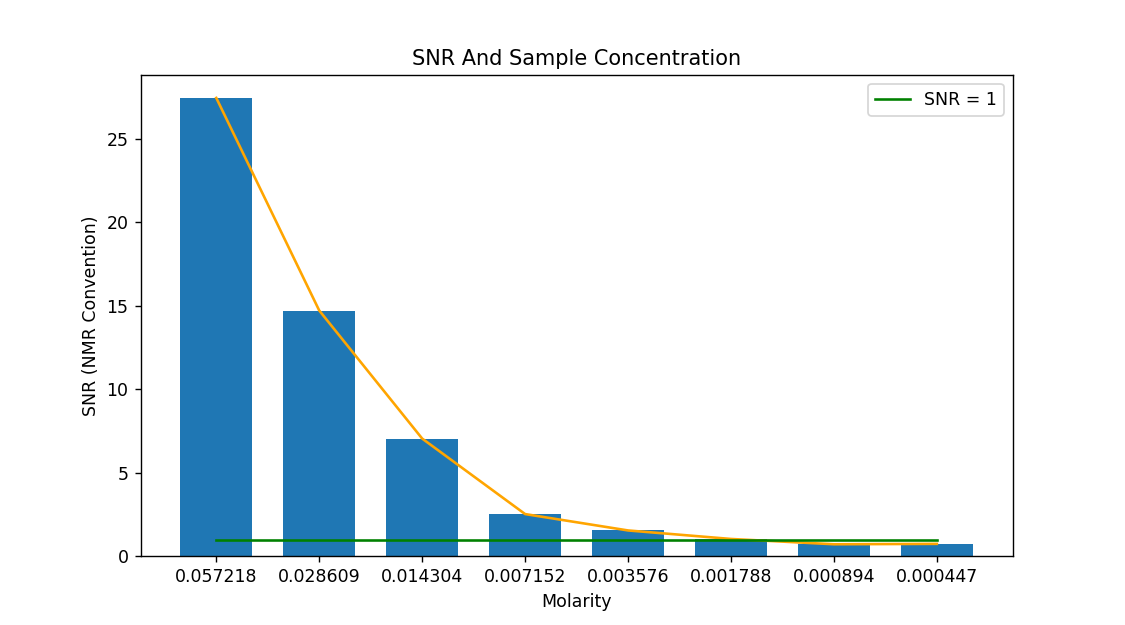

In [6]:
#Approximate the SNRs using one peak

#Extract the maximum from the peak at around 33ppm
p33_bounds = [8350, 8410]
signal_power = np.array([np.abs(np.abs(spectra[i][slice(p33_bounds[0], p33_bounds[1])])).max() for i in range(ns)])
    
#Extract the noise amplitude from between 100ppm and 50ppm
noise_bounds = [0, 8000]
noise_power = np.array([((np.abs(spectra[i][slice(noise_bounds[0], noise_bounds[1])])).max()) 
                        for i in range(ns)]) #max power

# noise_power = np.array([np.sqrt(np.average((np.abs(spectra[i][slice(noise_bounds[0], noise_bounds[1])]))**2)) 
#                         for i in range(ns)]) #RMS

SNR_plot = plt.figure(figsize=(9,5))
x = np.arange(ns)  # the label locations
width = 0.7  # the width of the bars
plt.xticks(x, [("%f" % (initial_concentration/2**i)) for i in range(ns)])
rects1 = plt.bar(x, signal_power/noise_power, width)
plt.plot(x, signal_power/noise_power, "orange")
plt.plot(x, [1 for _ in range(ns)], "green", label="SNR = 1")
plt.title("SNR And Sample Concentration")
plt.xlabel("Molarity")
plt.ylabel("SNR (NMR Convention)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


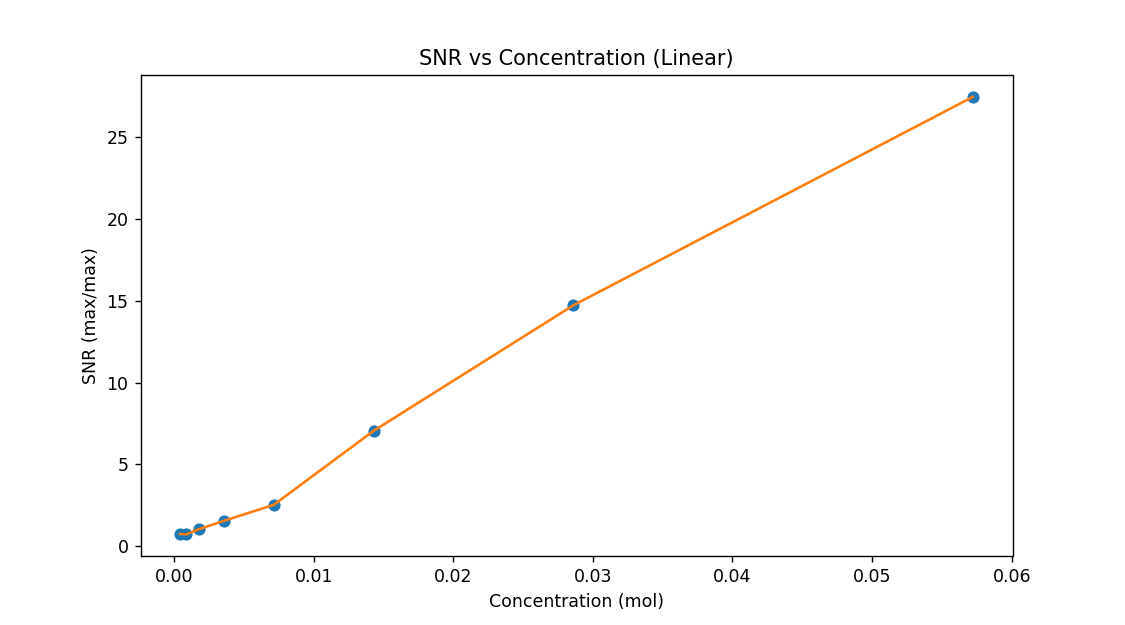

In [7]:
linfig = plt.figure(figsize=(9,5))
plt.title("SNR vs Concentration (Linear)")
plt.xlabel("Concentration (mol)")
plt.ylabel("SNR (max/max)")
plt.plot([(initial_concentration/2**i) for i in range(ns)], signal_power/noise_power, "o")
plt.plot([(initial_concentration/2**i) for i in range(ns)], signal_power/noise_power)
plt.show()

## Integrating Peaks

<IPython.core.display.Javascript object>


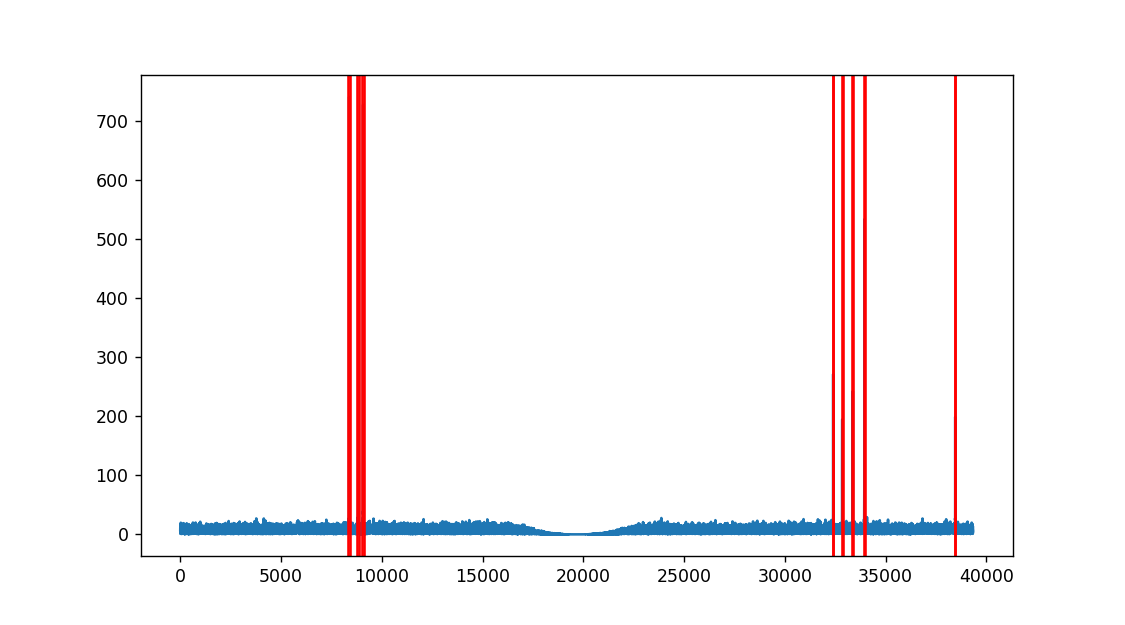

In [8]:
bounds = [
    [8343, 8425],
    [8794, 8877],
    [9037, 9116],
    [32386, 32409],
    [32828, 32859],
    [33351, 33388],
    [33921, 33983],
    [38443, 38462]
]

#plot the peaks so that we can identify bounds
bounds_plot = plt.figure(figsize=(9,5))
plt.plot(np.abs(spectra[0]))
for i in range(8):
    plt.axvline(bounds[i][0], color='r')
    plt.axvline(bounds[i][1], color='r')
plt.show()

<IPython.core.display.Javascript object>


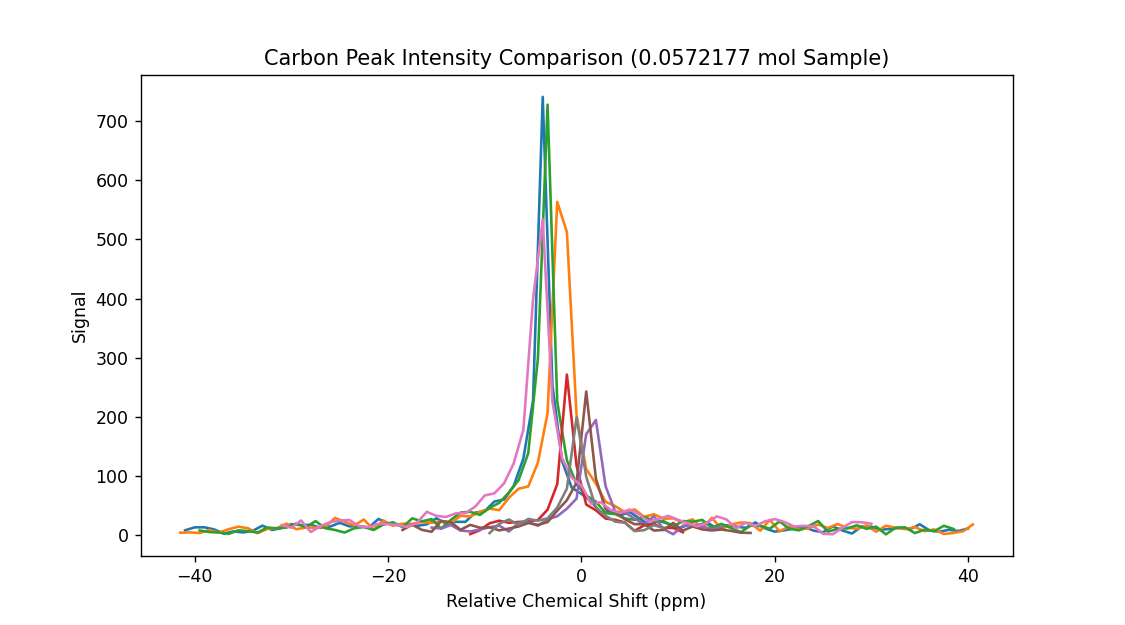

Peak Integrals:
	 3006.489112
	 3371.930688
	 3058.790899
	 901.574632
	 1006.646645
	 1003.568521
	 3212.895646
	 734.084537


In [16]:
#superimpose the peaks for visualization
peakplot = plt.figure(figsize=(9,5))
print("Peak Integrals:")
for i in range(8):
    lbound = bounds[i][0]
    ubound = bounds[i][1]
    x = np.array(range(ubound - lbound)) - (ubound - lbound)/2
    print("\t %f" % np.sum(np.abs(spectra[0,lbound:ubound])))
    plt.plot(x, np.abs(spectra[0,lbound:ubound]))
plt.title("Carbon Peak Intensity Comparison (0.0572177 mol Sample)")
plt.xlabel("Relative Chemical Shift (ppm)")
plt.ylabel("Signal")
plt.show()